In [35]:
import os
import random
from pathlib import Path
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader
import torchaudio
import logging
from copy import deepcopy
import csv
from typing import Callable, List, Optional, Tuple, Union
from collections import OrderedDict


### Utils

def find_wav_files(path_to_dir: Union[Path, str]) -> Optional[List[Path]]:
    """Find all wav files in the directory and its subtree.

    Args:
        path_to_dir: Path top directory.
    Returns:
        List containing Path objects or None (nothing found).
    """
    paths = list(sorted(Path(path_to_dir).glob("**/*.wav")))

    if len(paths) == 0:
        return None
    return paths


def set_seed(seed: int):
    """Fix PRNG seed for reproducable experiments.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

## Dataset-related code

**AudioDataset**: This dataset-related code processes a list of .wav files and adjusts the sample rate for each voice to be the same.





**PadDataset**: This function adjusts the length of all voices to 4 seconds. If the voice is longer than 4 seconds, it is truncated to between 0 and 4 seconds. If it is shorter than 4 seconds, it is played repeatedly to adjust the length to 4 seconds. Since the data is processed in mini-batches, this process can be seen as adjusting the length of each sample within the mini-batch to be the same.

**load_dataset**: This function loads the training dataset.

**load_dataset_test**: This function loads the test dataset.

##  dataset

In [36]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            directory_or_path_list: Union[Union[str, Path], List[Union[str, Path]]],
            sample_rate: int = 16_000,
            normalize: bool = True,
    ) -> None:
        super().__init__()

        self.sample_rate = sample_rate
        self.normalize = normalize

        # If input is directory, find all wav files
        if isinstance(directory_or_path_list, list):
            paths = directory_or_path_list
        elif isinstance(directory_or_path_list, (Path, str)):
            directory = Path(directory_or_path_list)
            if not directory.exists():
                raise IOError(f"Directory does not exist: {directory}")
            paths = find_wav_files(directory)
            if paths is None:
                raise IOError(f"No wav files found in {directory}")
        else:
            raise TypeError(f"Unsupported type: {type(directory_or_path_list)}")

        self._paths = paths

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        path = self._paths[index]
        waveform, sample_rate = torchaudio.load(path, normalize=self.normalize)

        if sample_rate != self.sample_rate:
            transform = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = transform(waveform)

        return waveform, sample_rate

    def __len__(self) -> int:
        return len(self._paths)

class PadDataset(torch.utils.data.Dataset):

    def __init__(self, dataset: torch.utils.data.Dataset, cut: int = 64600, label=None):
        self.dataset = dataset
        self.cut = cut  # max 4 sec (ASVSpoof default)
        self.label = label

    def __getitem__(self, index):
        waveform, sample_rate = self.dataset[index]
        waveform = waveform.squeeze(0)
        waveform_len = waveform.shape[0]
        if waveform_len >= self.cut:
            if self.label is None:
                return waveform[:self.cut], sample_rate
            else:
                return waveform[:self.cut], sample_rate, self.label
        # need to pad
        num_repeats = int(self.cut / waveform_len)+1
        padded_waveform = torch.tile(waveform, (1, num_repeats))[
            :, :self.cut][0]

        if self.label is None:
            return padded_waveform, sample_rate
        else:
            return padded_waveform, sample_rate, self.label

    def __len__(self):
        return len(self.dataset)
def load_dataset(
        path: Union[Path, str],
        pad: bool = False,
        train: str = 'train',
        real: str = 'real',
        label: Optional[int] = None,
        max_samples_per_class: Optional[int] = None,  # new argument
) -> torch.utils.data.Dataset:

    cur_path = f"{path}/{train}/{real}"
    paths = find_wav_files(cur_path)
    if paths is None:
        raise IOError(f"No files found in {cur_path}")

    # Subsample to max_samples_per_class if given
    if max_samples_per_class is not None and len(paths) > max_samples_per_class:
        paths = random.sample(paths, max_samples_per_class)

    LOGGER.info(f"Loading {len(paths)} samples from {cur_path}")

    dataset = AudioDataset(paths)
    if pad:
        dataset = PadDataset(dataset, label=label)

    return dataset


## Model-Related Code

**RawNet**: RawNet2 code

__init__: Creates the structure

__forward__: Performs forward propagation. For the input audio signal x, softmax() is used to calculate the probability of fake/real.

In [37]:
# raw_Net2

class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size,in_channels=1,sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):

        super(SincConv,self).__init__()

        if in_channels != 1:
            
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)
        
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device=device   
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        
        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')
        
        
        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)
        fmel=self.to_mel(f)   # Hz to mel conversion
        fmelmax=np.max(fmel)
        fmelmin=np.min(fmel)
        filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+1)
        filbandwidthsf=self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel=filbandwidthsf
        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels,self.kernel_size)
    
       
        
    def forward(self,x):
        for i in range(len(self.mel)-1):
            fmin=self.mel[i]
            fmax=self.mel[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow
            
            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)
        
        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)
        
        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)


        
class Residual_block(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block, self).__init__()
        self.first = first
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.3)
        
        self.conv1 = nn.Conv1d(in_channels = nb_filts[0],
			out_channels = nb_filts[1],
			kernel_size = 3,
			padding = 1,
			stride = 1)
        
        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1],
			out_channels = nb_filts[1],
			padding = 1,
			kernel_size = 3,
			stride = 1)
        
        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0],
				out_channels = nb_filts[1],
				padding = 0,
				kernel_size = 1,
				stride = 1)
            
        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)
        
    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(x)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)
        
        if self.downsample:
            identity = self.conv_downsample(identity)
            
        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()

        
        self.device=device

        self.Sinc_conv=SincConv(device=self.device,
			out_channels = d_args['filts'][0],
			kernel_size = d_args['first_conv'],
                        in_channels = d_args['in_channels']
        )
        
        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.selu = nn.SELU(inplace=True)
        self.block0 = Residual_block(nb_filts = d_args['filts'][1], first = True)
        self.block1 = Residual_block(nb_filts = d_args['filts'][1])
        self.block2 = Residual_block(nb_filts = d_args['filts'][2])
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = Residual_block(nb_filts = d_args['filts'][2])
        self.block4 = Residual_block(nb_filts = d_args['filts'][2])
        self.block5 = Residual_block(nb_filts = d_args['filts'][2])
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc_attention0 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1],
			hidden_size = d_args['gru_node'],
			num_layers = d_args['nb_gru_layer'],
			batch_first = True)

        
        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'],
			out_features = d_args['nb_fc_node'])
       
        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'],
			out_features = d_args['nb_classes'],bias=True)
			
       
        self.sig = nn.Sigmoid()
        
    def forward(self, x, y = None):
        
        
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x=x.view(nb_samp,1,len_seq)
        
        x = self.Sinc_conv(x)    
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x =  self.selu(x)
        
        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1) # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)
        

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1) # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1 # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1) # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2 # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1) # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3 # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1) # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4 # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1) # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5 # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.permute(0, 2, 1)     #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        x = self.fc1_gru(x)
        x = self.fc2_gru(x).softmax(dim=1)
        output = x
        return output


    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
			        out_features = l_out_features))
        return nn.Sequential(*l_fc)


## Training-related code

**GDTrainer**

train

Creates training and validation data loaders

The loss function uses cross entropy.

The optimizer uses Adam.

Includes training and validation details for each epoch: After each epoch of training is completed, validation is performed and the accuracy for each epoch is calculated.

test

Loads the model with the highest validation accuracy and performs testing.



In [38]:
class Trainer(object):
    def __init__(self,
                 epochs: int = 20,
                 batch_size: int = 16,
                 device: str = "cpu",
                 optimizer_fn: Callable = torch.optim.Adam,
                 optimizer_kwargs: dict = {"lr": 1e-3},
                 ) -> None:
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.optimizer_fn = optimizer_fn
        self.optimizer_kwargs = optimizer_kwargs
        self.epoch_test_losses: List[float] = []



class GDTrainer(Trainer):
    def train(self,
              dataset_train: torch.utils.data.Dataset,
              dataset_validation: torch.utils.data.Dataset,
              model: torch.nn.Module,
              model_dir: str,
              ):

        train_loader = DataLoader(
            dataset_train, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=4)
        validation_loader = DataLoader(
            dataset_validation, batch_size=self.batch_size, drop_last=True, num_workers=4)

        criterion = torch.nn.CrossEntropyLoss()
        optim = self.optimizer_fn(model.parameters(), **self.optimizer_kwargs)

        best_model = None
        best_acc = 0
        for epoch in range(self.epochs):
            running_loss = 0
            num_correct = 0.0
            num_total = 0.0
            model.train()

            for i, (batch_x, _, batch_y) in enumerate(train_loader):
                batch_size = batch_x.size(0)
                num_total += batch_size

                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                batch_out = model(batch_x)
                batch_loss = criterion(batch_out, batch_y)

                _, batch_pred = batch_out.max(dim=1)
                num_correct += (batch_pred == batch_y).sum(dim=0).item()


                running_loss += (batch_loss.item() * batch_size)
                
                if i % (train_loader.__len__() // 20) == 0:
                    cur_loss = batch_loss
                    LOGGER.info(f"[{epoch:04d}] {i}/{train_loader.__len__()}: {cur_loss}")

                optim.zero_grad()
                batch_loss.backward()
                optim.step()

            running_loss /= num_total
            train_accuracy = (num_correct/num_total)*100
            
            
            num_correct = 0.0
            num_total = 0.0
            model.eval()
            for batch_x, _, batch_y in validation_loader:

                batch_size = batch_x.size(0)
                num_total += batch_size
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                batch_out = model(batch_x)

                _, batch_pred = batch_out.max(dim=1)
                num_correct += (batch_pred == batch_y).sum(dim=0).item()

            valid_acc = 100 * (num_correct / num_total)

            if best_model is None or valid_acc > best_acc:
                best_acc = valid_acc
                best_model = deepcopy(model.state_dict())
                save_model(model, model_dir,epoch)

            LOGGER.info(
                f"[{epoch:04d}]: {running_loss} - train acc: {train_accuracy} - valid_acc: {valid_acc}")

        model.load_state_dict(best_model)
        return model
    
    def test(self,
              dataset_test: torch.utils.data.Dataset,
              model: torch.nn.Module,
              ):
        model.eval()
        test_loader = DataLoader(
            dataset_test, batch_size=1, drop_last=False)
        
        f = open('submission.csv', 'w', newline='')
        wr = csv.writer(f)
        wr.writerow(['Id', 'Predicted'])

        for i, (batch_x, _, batch_y) in enumerate(test_loader):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                batch_out = model(batch_x)

                _, batch_pred = batch_out.max(dim=1)

                wr.writerow([i+1, batch_pred[0].item()])
        f.close()


## Main code


In [40]:
import logging
from pathlib import Path
import torch
from torch.utils.data import ConcatDataset, DataLoader, Subset
from copy import deepcopy
from typing import Union

# ---------------------------
# Logger
# ---------------------------
LOGGER = logging.getLogger(__name__)

def init_logger(log_file="experiments.log"):
    LOGGER.setLevel(logging.INFO)
    fh = logging.FileHandler(log_file)
    ch = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    if not LOGGER.handlers:
        LOGGER.addHandler(fh)
        LOGGER.addHandler(ch)

# ---------------------------
# RawNet config
# ---------------------------
RAW_NET_CONFIG = {
    "nb_samp": 64600,
    "first_conv": 1024,
    "in_channels": 1,
    "filts": [20, [20, 20], [20, 128], [128, 128]],
    "blocks": [2, 4],
    "nb_fc_node": 1024,
    "gru_node": 1024,
    "nb_gru_layer": 3,
    "nb_classes": 2,
}

# ---------------------------
# Test dataset loader
# ---------------------------
def load_dataset_test(path: Union[Path, str], pad: bool = True):
    paths = find_wav_files(path)
    if paths is None:
        raise IOError(f"No files found in {path}!")
    dataset = AudioDataset(paths)
    if pad:
        dataset = PadDataset(dataset, label=None)
    return dataset

# ---------------------------
# Training function
# ---------------------------
def train_raw_net(
        base_dir: Union[Path, str],
        test_dir: Union[Path, str],
        batch_size: int = 16,
        epochs: int = 3,
        device: str = "cuda",
        model_dir: Path = None,
        max_train_samples: int = 1000,  
        max_val_samples: int = 500,     
        max_test_samples: int = 1000    
):
    LOGGER.info("Loading datasets...")

    # Balanced training datasets
    real_train = load_dataset(base_dir, pad=True, train='train', real='real', label=1, max_samples_per_class=max_train_samples)
    fake_train = load_dataset(base_dir, pad=True, train='train', real='fake', label=0, max_samples_per_class=max_train_samples)
    train_dataset = ConcatDataset([real_train, fake_train])

    real_val = load_dataset(base_dir, pad=True, train='validation', real='real', label=1, max_samples_per_class=max_val_samples)
    fake_val = load_dataset(base_dir, pad=True, train='validation', real='fake', label=0, max_samples_per_class=max_val_samples)
    val_dataset = ConcatDataset([real_val, fake_val])

    # Test dataset (limited for quick testing)
    full_test_dataset = load_dataset_test(test_dir, pad=True)
    test_dataset = Subset(full_test_dataset, list(range(min(max_test_samples, len(full_test_dataset)))))

    LOGGER.info(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

    # ---------------------------
    # Initialize model
    # ---------------------------
    model = RawNet(deepcopy(RAW_NET_CONFIG), device).to(device)
    LOGGER.info("RawNet model initialized.")

    # ---------------------------
    # Initialize trainer
    # ---------------------------
    trainer = GDTrainer(batch_size=batch_size, device=device, epochs=epochs)

    # --- MODIFIED: capture epoch-wise metrics ---
    model, epoch_train_losses, epoch_val_accuracies = trainer.train(
        dataset_train=train_dataset,
        dataset_validation=val_dataset,
        model=model,
        model_dir=model_dir
    )

    LOGGER.info("Training complete!")

    return model, train_dataset, val_dataset, test_dataset, epoch_train_losses, epoch_val_accuracies

# ---------------------------
# Main
# ---------------------------
def main():
    set_seed(42)
    init_logger()

    device = "cuda"
    base_dir = '/kaggle/input/2024-jbnu-competition-revised'
    test_dir = '/kaggle/input/2024-jbnu-competition-revised/test'

    batch_size = 16
    epochs = 10

    # Model directory
    model_dir = Path("trained_models")
    model_dir.mkdir(exist_ok=True, parents=True)

    # --- TRAIN MODEL ---
    model, train_dataset, val_dataset, test_dataset, epoch_train_losses, epoch_val_accuracies = train_raw_net(
        base_dir=base_dir,
        test_dir=test_dir,
        batch_size=batch_size,
        epochs=epochs,
        device=device,
        model_dir=model_dir,
        max_train_samples=10000,   
        max_val_samples=3000,      
        max_test_samples=1000     
    )

    # Save variables globally if needed
    globals().update({
        'model': model,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'device': device,
        'epoch_train_losses': epoch_train_losses,
        'epoch_val_accuracies': epoch_val_accuracies
    })

if __name__ == "__main__":
    main()


2025-09-30 13:54:45,795 - INFO - Loading datasets...
2025-09-30 13:55:07,349 - INFO - Loading 10000 samples from /kaggle/input/2024-jbnu-competition-revised/train/real
2025-09-30 13:57:19,029 - INFO - Loading 10000 samples from /kaggle/input/2024-jbnu-competition-revised/train/fake
2025-09-30 13:57:24,867 - INFO - Loading 3000 samples from /kaggle/input/2024-jbnu-competition-revised/validation/real
2025-09-30 13:58:05,127 - INFO - Loading 3000 samples from /kaggle/input/2024-jbnu-competition-revised/validation/fake
2025-09-30 13:59:27,682 - INFO - Train samples: 20000 | Validation samples: 6000 | Test samples: 1000
2025-09-30 13:59:27,865 - INFO - RawNet model initialized.
2025-09-30 13:59:28,749 - INFO - [0000] 0/1250: 0.6911762952804565
2025-09-30 13:59:39,198 - INFO - [0000] 62/1250: 0.750761866569519
2025-09-30 13:59:49,459 - INFO - [0000] 124/1250: 0.8132619261741638
2025-09-30 13:59:59,123 - INFO - [0000] 186/1250: 0.7507619261741638
2025-09-30 14:00:08,992 - INFO - [0000] 248/12

TypeError: cannot unpack non-iterable RawNet object

In [ ]:
import logging
from pathlib import Path
import torch
from torch.utils.data import ConcatDataset, DataLoader, Subset
from copy import deepcopy
from typing import Union

# ---------------------------
# Logger
# ---------------------------
LOGGER = logging.getLogger(__name__)

def init_logger(log_file="experiments.log"):
    LOGGER.setLevel(logging.INFO)
    fh = logging.FileHandler(log_file)
    ch = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    if not LOGGER.handlers:
        LOGGER.addHandler(fh)
        LOGGER.addHandler(ch)

# ---------------------------
# RawNet config
# ---------------------------
RAW_NET_CONFIG = {
    "nb_samp": 64600,
    "first_conv": 1024,
    "in_channels": 1,
    "filts": [20, [20, 20], [20, 128], [128, 128]],
    "blocks": [2, 4],
    "nb_fc_node": 1024,
    "gru_node": 1024,
    "nb_gru_layer": 3,
    "nb_classes": 2,
}

# ---------------------------
# Test dataset loader
# ---------------------------
def load_dataset_test(path: Union[Path, str], pad: bool = True):
    paths = find_wav_files(path)
    if paths is None:
        raise IOError(f"No files found in {path}!")
    dataset = AudioDataset(paths)
    if pad:
        dataset = PadDataset(dataset, label=None)
    return dataset

# ---------------------------
# Training function
# ---------------------------
def train_raw_net(
        base_dir: Union[Path, str],
        test_dir: Union[Path, str],
        batch_size: int = 16,
        epochs: int = 3,
        device: str = "cuda",
        model_dir: Path = None,
        max_train_samples: int = 1000,  
        max_val_samples: int = 500,     
        max_test_samples: int = 1000    
):
    LOGGER.info("Loading datasets...")

    # Balanced training datasets
    real_train = load_dataset(base_dir, pad=True, train='train', real='real', label=1, max_samples_per_class=max_train_samples)
    fake_train = load_dataset(base_dir, pad=True, train='train', real='fake', label=0, max_samples_per_class=max_train_samples)
    train_dataset = ConcatDataset([real_train, fake_train])

    real_val = load_dataset(base_dir, pad=True, train='validation', real='real', label=1, max_samples_per_class=max_val_samples)
    fake_val = load_dataset(base_dir, pad=True, train='validation', real='fake', label=0, max_samples_per_class=max_val_samples)
    val_dataset = ConcatDataset([real_val, fake_val])

    # Test dataset (limited for quick testing)
    full_test_dataset = load_dataset_test(test_dir, pad=True)
    test_dataset = Subset(full_test_dataset, list(range(min(max_test_samples, len(full_test_dataset)))))

    LOGGER.info(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

    # ---------------------------
    # Initialize model
    # ---------------------------
    model = RawNet(deepcopy(RAW_NET_CONFIG), device).to(device)
    LOGGER.info("RawNet model initialized.")

    # ---------------------------
    # Initialize trainer
    # ---------------------------
    trainer = GDTrainer(batch_size=batch_size, device=device, epochs=epochs)

    # --- MODIFIED: capture epoch-wise metrics ---
    model, epoch_train_losses, epoch_val_accuracies = trainer.train(
        dataset_train=train_dataset,
        dataset_validation=val_dataset,
        model=model,
        model_dir=model_dir
    )

    LOGGER.info("Training complete!")

    return model, train_dataset, val_dataset, test_dataset, epoch_train_losses, epoch_val_accuracies

# ---------------------------
# Main
# ---------------------------
def main():
    set_seed(42)
    init_logger()

    device = "cuda"
    base_dir = '/kaggle/input/2024-jbnu-competition-revised'
    test_dir = '/kaggle/input/2024-jbnu-competition-revised/test'

    batch_size = 16
    epochs = 25

    # Model directory
    model_dir = Path("trained_models")
    model_dir.mkdir(exist_ok=True, parents=True)

    # --- TRAIN MODEL ---
    model, train_dataset, val_dataset, test_dataset, epoch_train_losses, epoch_val_accuracies = train_raw_net(
        base_dir=base_dir,
        test_dir=test_dir,
        batch_size=batch_size,
        epochs=epochs,
        device=device,
        model_dir=model_dir,
        max_train_samples=10000,   
        max_val_samples=3000,      
        max_test_samples=1000     
    )

    # Save variables globally if needed
    globals().update({
        'model': model,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'device': device,
        'epoch_train_losses': epoch_train_losses,
        'epoch_val_accuracies': epoch_val_accuracies
    })

if __name__ == "__main__":
    main()


2025-09-30 14:44:37,795 - INFO - Loading datasets...
2025-09-30 14:45:17,349 - INFO - Loading 10000 samples from /kaggle/input/2024-jbnu-competition-revised/train/real
2025-09-30 14:47:28,029 - INFO - Loading 10000 samples from /kaggle/input/2024-jbnu-competition-revised/train/fake
2025-09-30 14:47:26,867 - INFO - Loading 3000 samples from /kaggle/input/2024-jbnu-competition-revised/validation/real
2025-09-30 14:48:45,127 - INFO - Loading 3000 samples from /kaggle/input/2024-jbnu-competition-revised/validation/fake
2025-09-30 14:49:36,682 - INFO - Train samples: 20000 | Validation samples: 6000 | Test samples: 1000
2025-09-30 14:50:39,865 - INFO - RawNet model initialized.
2025-09-30 14:50:39,000 - INFO - [0000] 0/1250: 1.002471833
2025-09-30 14:50:47,970 - INFO - [0000] 62/1250: 0.533623908
2025-09-30 14:50:59,337 - INFO - [0000] 124/1250: 0.728589981
2025-09-30 14:51:07,469 - INFO - [0000] 186/1250: 0.864080613
2025-09-30 14:51:16,136 - INFO - [0000] 248/1250: 0.722335333
2025-09-30 

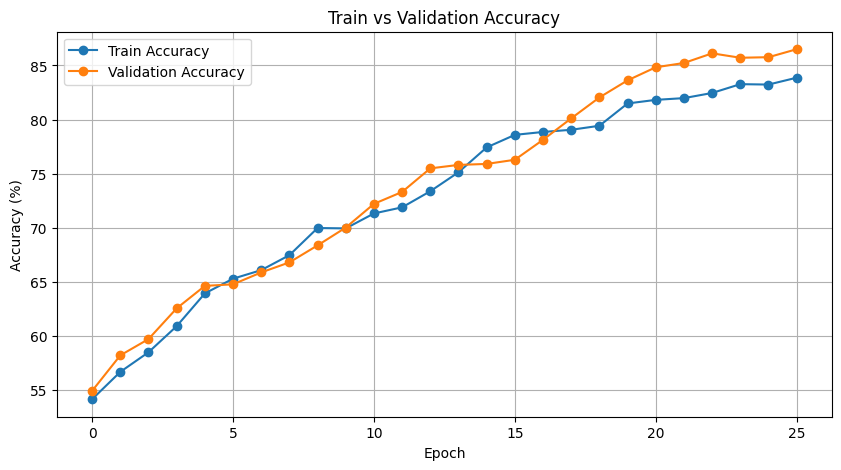

In [ ]:
import matplotlib.pyplot as plt

def plot_train_val_accuracy(epoch_train_accuracies, epoch_val_accuracies):
    """
    Plot training and validation accuracy over epochs.

    Parameters:
    - epoch_train_accuracies: list of training accuracies per epoch
    - epoch_val_accuracies: list of validation accuracies per epoch
    """
    epochs = range(1, len(epoch_train_accuracies) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, epoch_train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, epoch_val_accuracies, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train & Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()
